In [24]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython import display
from torchvision import datasets, transforms
import os

np.random.seed(1112)

### Dataset

In [25]:
# Training Flags (hyperparameter configuration)
height = 28
width = 28
x_dim = height * width
z_dim = 2

In [26]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    ])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    ])

# choose the training and test datasets
train_data = datasets.MNIST('mnist_data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('mnist_data', train=False, download=True, transform=test_transform)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=len(train_data))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))

In [27]:
X = next(iter(train_loader))[0].numpy().reshape([-1, x_dim])
print(X.shape)

X_indexes = np.random.randint(0, len(X), 1000)
X = X[X_indexes]
print(X.shape)

t = next(iter(train_loader))[1].numpy()[X_indexes]
print(t.shape)

(60000, 784)
(1000, 784)
(1000,)


### Covariance Matrix (biased) Functions

$S=\frac{1}{N}\sum_{n=1}^{N}(x_n-\bar x)(x_n-\bar x)^T$

$\bar x=\frac{1}{N}\sum_{n=1}^{N}x_n$

In [28]:
from numpy import linalg

# Using the definition
def covariance_matrix1(X):
    # X : (batch, dim)
    batch, dim = X.shape
    
    X_mean = X.mean(axis=0, keepdims=True)
    X_cov = np.zeros(shape=(dim, dim))
    for i in range(batch):
        # (1, dim)
        S = X[i:i+1] - X_mean
        # (dim, dim)
        X_cov += S.T @ S
        
    X_cov = X_cov / batch
    
    return X_cov

# Using matrix multiplication
def covariance_matrix2(X):
    # X : (batch, dim)
    batch, dim = X.shape
    X_mean = X.mean(axis=0, keepdims=True)
    X_cov = (X-X_mean).T @ (X-X_mean) / batch
    
    return X_cov

# Using numpy library
def covariance_matrix3(X):
    # X : (batch, dim)
    
    X_cov = np.cov(X.T, bias=True)
    
    return X_cov

### Get eigenvectors of the covariance matrix of the dataset

In [29]:
from numpy import linalg

# The mean of the dataset
X_mean = X.mean(axis=0, keepdims=True)
# The covariance matrix of the dataset
X_cov = covariance_matrix2(X)

# Get eigenvectors, (x_dim, x_dim)
_, v = linalg.eig(X_cov)
# Get the basis of Z-space = The largest eigenvectors
basis = v[:, :z_dim].real
print('Basis shape :', basis.shape)
inv_basis = np.linalg.pinv(basis)
print('Pseudo inverse basis shape :', inv_basis.shape)


Basis shape : (784, 2)
Pseudo inverse basis shape : (2, 784)


### Plot the basis

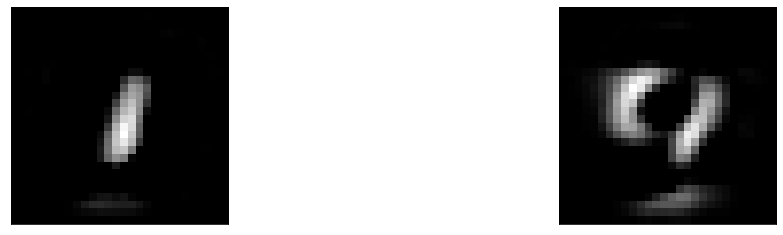

In [30]:
plt.figure(figsize=[18, 4])
for i in range(z_dim):
    plt.subplot(1, z_dim, i+1)
    plt.imshow(np.clip(basis.reshape(height, width, z_dim)[:, :, i], 0, 1), cmap='gray')
    plt.xticks([], [])
    plt.yticks([], [])
plt.show()

### Do PCA

In [31]:
Z = (X - X_mean) @ basis
print('Z shape :', Z.shape)

Z shape : (1000, 2)


In [32]:
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

### Plot 

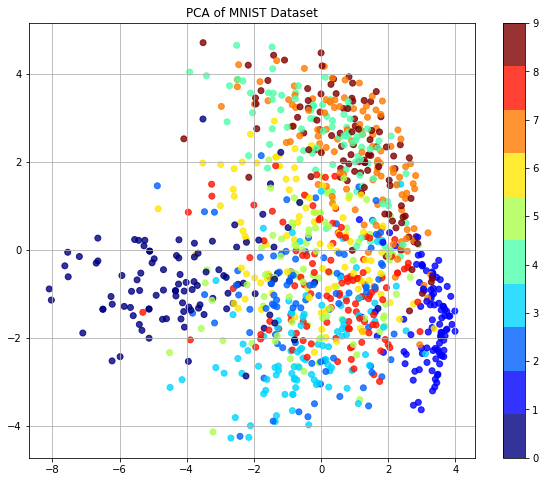

In [33]:
plt.figure(figsize=[10, 8])
plt.title('PCA of MNIST Dataset')
plt.scatter(Z[:, 0], Z[:, 1], c=t, cmap=discrete_cmap(10, 'jet'), alpha=0.8)
plt.colorbar()
plt.grid()
plt.show()

### Reconstruction using pseudo inverse matrix

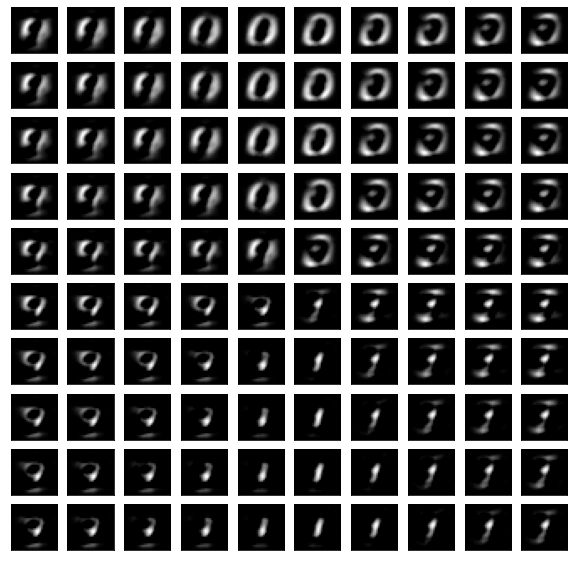

In [34]:
x_grid = np.linspace(-4, 4, 10)
y_grid = np.linspace(4, -4, 10)
xv, yv = np.meshgrid(x_grid, y_grid)
Z_samples = np.stack([xv, yv], axis=2)

plt.figure(figsize=[10, 10])
for x_index in range(10):
    for y_index in range(10):
        z = Z_samples[x_index][y_index][:, None]
        x = np.clip((inv_basis.T @ z + X_mean)[:, 0], 0, 1)
        
        plt.subplot(10, 10, x_index + 1 + y_index * 10)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.imshow(x.reshape((height, width)), cmap='gray')
        
plt.show()